In [1]:
# This takes opto trigger aligned data and run UMAP on the set of trajectories to uncover structure

In [2]:
import numpy as np
import pandas as pd
import umap
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

/Users/bdeangelis/.pyenv/versions/methods-3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/bdeangelis/.pyenv/versions/methods-3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# data_path = '/Users/bdeangelis/Desktop/Datasets/OptoMethodDatasets/csv/trials.csv'
data_path = '/Users/bdeangelis/Desktop/Datasets/OptoMethodDatasets/csv/trials-withBody.csv'

# Load the dataset (Setting the index and column headers appropriately)
trials = pd.read_csv(data_path, header=[0,1], index_col=[0,1,2])

# Flags for data inclusion in UMAP embedding
body_flag = True
limb_flag = False

In [4]:
print(trials.shape)
trials.head()

(12342, 465)


L1_xPlot_mm                      \
time                                             0         1         2   
trial_id condition            hit_type                                   
1        Bristle-Chrimson.csv R2          0.470877  0.450157  0.491509   
2        Bristle-Chrimson.csv R2          0.450157  0.491509  0.442105   
3        Bristle-Chrimson.csv R2          0.647632  0.706364  0.693972   
4        Bristle-Chrimson.csv R2          0.706364  0.693972  0.667726   
5        Bristle-Chrimson.csv R2          0.693972  0.667726  0.678337   

                                                                      \
time                                           3         4         5   
trial_id condition            hit_type                                 
1        Bristle-Chrimson.csv R2        0.442105  0.464421  0.475645   
2        Bristle-Chrimson.csv R2        0.464421  0.475645  0.463474   
3        Bristle-Chrimson.csv R2        0.667726  0.678337  0.707279   
4        Bristle-Chrimson.csv R2        0.678337  0.707279  0.671954   
5        Bristle-Chrimson.csv R2        0.707279  0.671954  0.648353   

                                                                      \
time                                           6         7         8   
trial_id condition            hit_type                                 
1        Bristle-Chrimson.csv R2        0.463474  0.481912  0.461916   
2        Bristle-Chrimson.csv R2        0.481912  0.461916  0.452702   
3        Bristle-Chrimson.csv R2        0.671954  0.648353  0.676088   
4        Bristle-Chrimson.csv R2        0.648353  0.676088  0.660789   
5        Bristle-Chrimson.csv R2        0.676088  0.660789  0.675602   

                                                  ...  \
time                                           9  ...   
trial_id condition            hit_type            ...   
1        Bristle-Chrimson.csv R2        0.452702  ...   
2        Bristle-Chrimson.csv R2        0.481570  ...   
3        Bristle-Chrimson.csv R2        0.660789  ...   
4        Bristle-Chrimson.csv R2        0.675602  ...   
5        Bristle-Chrimson.csv R2        0.637204  ...   

                                       translationalSpeed_mmPerSec            \
time                                                            21        22   
trial_id condition            hit_type                                         
1        Bristle-Chrimson.csv R2                          0.449429 -0.519119   
2        Bristle-Chrimson.csv R2                         -0.519119  0.231451   
3        Bristle-Chrimson.csv R2                         -0.147234  0.153937   
4        Bristle-Chrimson.csv R2                          0.153937 -1.067498   
5        Bristle-Chrimson.csv R2                         -1.067498 -0.818884   

                                                                      \
time                                          23        24        25   
trial_id condition            hit_type                                 
1        Bristle-Chrimson.csv R2        0.231451 -0.290454  0.127350   
2        Bristle-Chrimson.csv R2       -0.290454  0.127350 -0.304706   
3        Bristle-Chrimson.csv R2       -1.067498 -0.818884 -0.007303   
4        Bristle-Chrimson.csv R2       -0.818884 -0.007303 -0.313569   
5        Bristle-Chrimson.csv R2       -0.007303 -0.313569 -0.685924   

                                                                      \
time                                          26        27        28   
trial_id condition            hit_type                                 
1        Bristle-Chrimson.csv R2       -0.304706  0.295863 -0.103467   
2        Bristle-Chrimson.csv R2        0.295863 -0.103467 -0.514919   
3        Bristle-Chrimson.csv R2       -0.313569 -0.685924  0.185393   
4        Bristle-Chrimson.csv R2       -0.685924  0.185393  0.367556   
5        Bristle-Chrimson.csv R2        0.185393  0.367556  0.098728   

                                        

In [5]:
# Compute some additional labels based on pre-stimulus and post-stimulus integreated values
# NOTE: winlen = 15 thus:
# prestimlus --> 0-14 
# hit onset --> 15
# post stimulus --> 16-30

body_vars = pd.DataFrame(columns=['pre_v_par', 'pre_v_perp', 'pre_v_rot', 'post_v_par', 'post_v_perp', 'post_v_rot'])

body_vars.pre_v_par = np.mean(trials.loc[:,[('forwardSpeed_mmPerSec', str(x)) for x in range(15)]],axis=1)
body_vars.pre_v_perp = np.sum(trials.loc[:,[('translationalSpeed_mmPerSec', str(x)) for x in range(15)]],axis=1)
body_vars.pre_v_rot = np.sum(trials.loc[:,[('angVel_radPerSec', str(x)) for x in range(15)]],axis=1)

body_vars.post_v_par = np.mean(trials.loc[:,[('forwardSpeed_mmPerSec', str(x)) for x in range(16, 31)]],axis=1)
body_vars.post_v_perp = np.sum(trials.loc[:,[('translationalSpeed_mmPerSec', str(x)) for x in range(16, 31)]],axis=1)
body_vars.post_v_rot = np.sum(trials.loc[:,[('angVel_radPerSec', str(x)) for x in range(16, 31)]],axis=1)

print(body_vars.shape)

(12342, 6)


In [6]:
# Define the lists of columns associated with the body and limbs respectively
body_list = ['forwardSpeed_mmPerSec', 'translationalSpeed_mmPerSec', 'angVel_radPerSec']
limb_list = ['L1_xPlot_mm', 'L1_yPlot_mm', 'L2_xPlot_mm', 'L2_yPlot_mm', 
             'L3_xPlot_mm', 'L3_yPlot_mm', 'R1_xPlot_mm', 'R1_yPlot_mm',
             'R2_xPlot_mm', 'R2_yPlot_mm', 'R3_xPlot_mm', 'R3_yPlot_mm']

In [7]:
# Remove the trials that contain nan values
nan_bool = trials.isnull().any(axis=1)
body_vars = body_vars[~nan_bool]
trials = trials[~nan_bool]
print(trials.shape)

# Decide what data to include in the UMAP embedding
if body_flag & limb_flag:
    # Keep all data
    data = trials.values.astype(np.float32)
elif body_flag:
    # Keep only the body data
    data = trials.loc[:,body_list].values.astype(np.float32)
elif limb_flag:
    # Keep only the limb data
    data = trials.loc[:,limb_list].values.astype(np.float32)
else:
    raise valueError('No data selected for UMAP embedding')

# Store the trial labels
labels = trials.index.values

(12306, 465)


In [8]:
# Setup UMAP
n_neighbors = 1000
min_dist = 0.0
n_components = 3
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                    n_components=n_components, metric=metric)

# Run UMAP
embedding = reducer.fit_transform(data)


/Users/bdeangelis/.pyenv/versions/methods-3.7.4/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../.pyenv/versions/methods-3.7.4/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/bdeangelis/.pyenv/versions/methods-3.7.4/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics 

In [9]:
embedding.shape

(12306, 3)

In [10]:
# Create a dataFrame to store the results
df = pd.DataFrame(embedding, columns=('x', 'y', 'z'))
# df = pd.DataFrame(embedding, columns=('x', 'y'))
df['Hit_Type'] = pd.Series([str(x[2]) for x in labels], dtype="category")
df['Condition'] = pd.Series([str(x[1].split('.')[0]) for x in labels], dtype="category")
df['Combo'] = pd.Series([str(x[1].split('.')[0]+'+'+x[2][0]) for x in labels], dtype="category")
# df['Combo'] = pd.Series([str(x[1]+'+'+x[2][0]) for x in labels], dtype="category")
# df['Combo'] = pd.Series([str(x[1]+'+'+x[2]) for x in labels], dtype="category")

# # Make Combination Labels for Left and Right for each condition
# df['Hit_Side'] = df['Hit_Type'].values[0]

# Add the body velocity variables to the output dataFrame
body_vars.reset_index(inplace=True)
df['pre_v_par'] = body_vars['pre_v_par']
df['pre_v_perp'] = body_vars['pre_v_perp']
df['pre_v_rot'] = body_vars['pre_v_rot']

df['post_v_par'] = body_vars['post_v_par']
df['post_v_perp'] = body_vars['post_v_perp']
df['post_v_rot'] = body_vars['post_v_rot']

df.head()

,x,y,z,Hit_Type,Condition,Combo,pre_v_par,pre_v_perp,pre_v_rot,post_v_par,post_v_perp,post_v_rot
0,-8.795510,-3.400101,-2.170602,R2,Bristle-Chrimson,Bristle-Chrimson+R,-0.020515,-0.037792,-0.413670,0.005825,-0.588877,0.054276
1,-8.909816,-3.628189,-1.630668,R2,Bristle-Chrimson,Bristle-Chrimson+R,-0.005583,-0.146836,-0.376255,0.011718,-0.608518,1.130072
2,-2.885954,-2.577018,-0.138606,R2,Bristle-Chrimson,Bristle-Chrimson+R,0.997223,-8.342319,1.029130,1.693058,-2.037421,-0.290129
3,-2.868501,-2.453369,-0.172431,R2,Bristle-Chrimson,Bristle-Chrimson+R,1.139260,-7.530229,1.345622,1.746315,-2.974011,-0.212614
4,-2.920507,-2.568486,-0.173714,R2,Bristle-Chrimson,Bristle-Chrimson+R,1.010227,-6.982109,0.277973,1.789557,-1.708358,0.346310


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


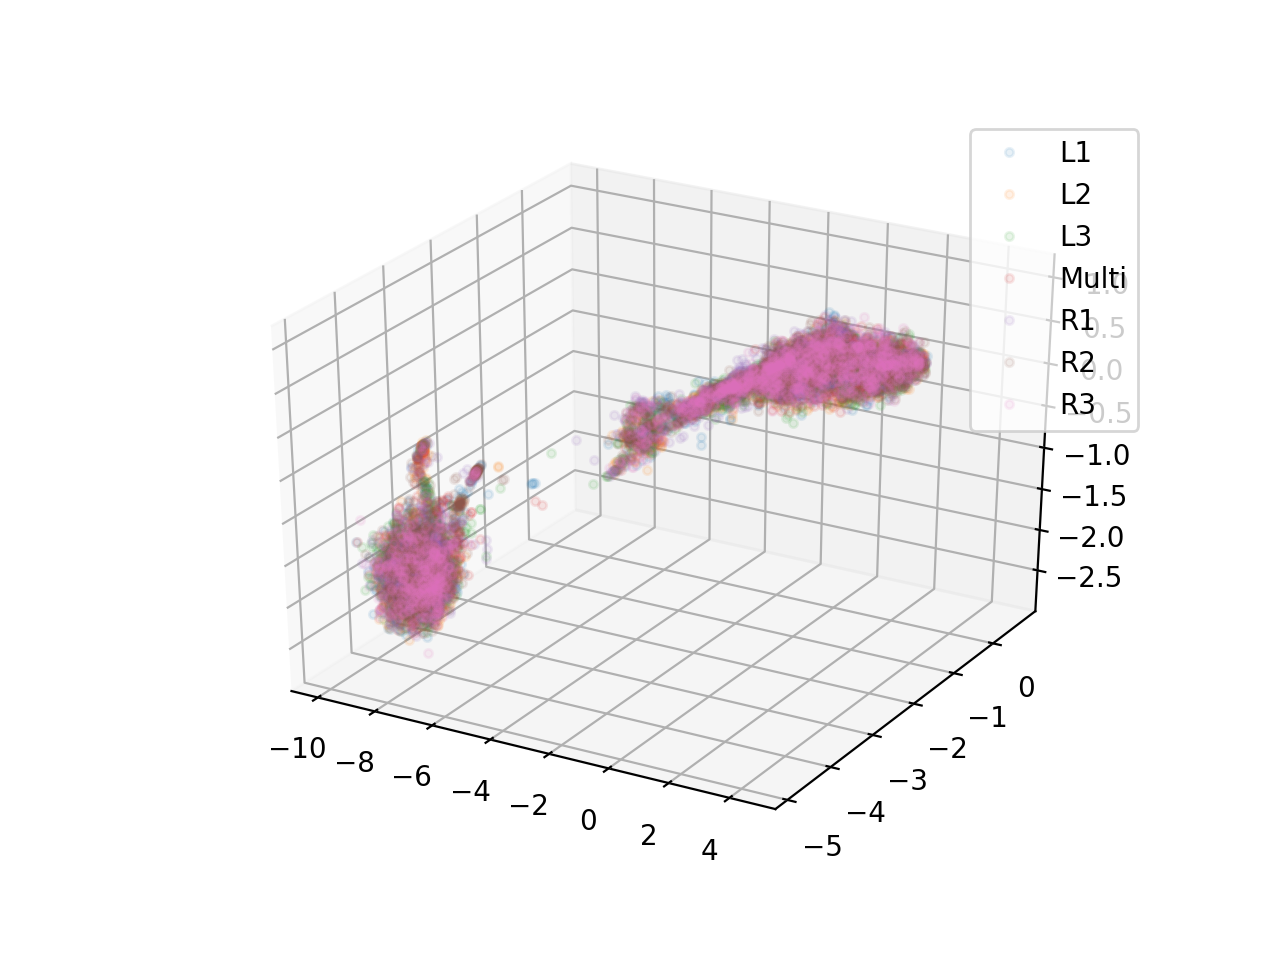

In [11]:
%matplotlib
# Make a plot colored by Hit_Type
groups = df.groupby('Hit_Type')
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax = plt.axes()
for name, group in groups:
    ax.plot(group.x, group.y, group.z,  marker='.', linestyle='', alpha=.1, label=name)
#     ax.plot(group.x, group.y,  marker='.', linestyle='', alpha=.1, label=name)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


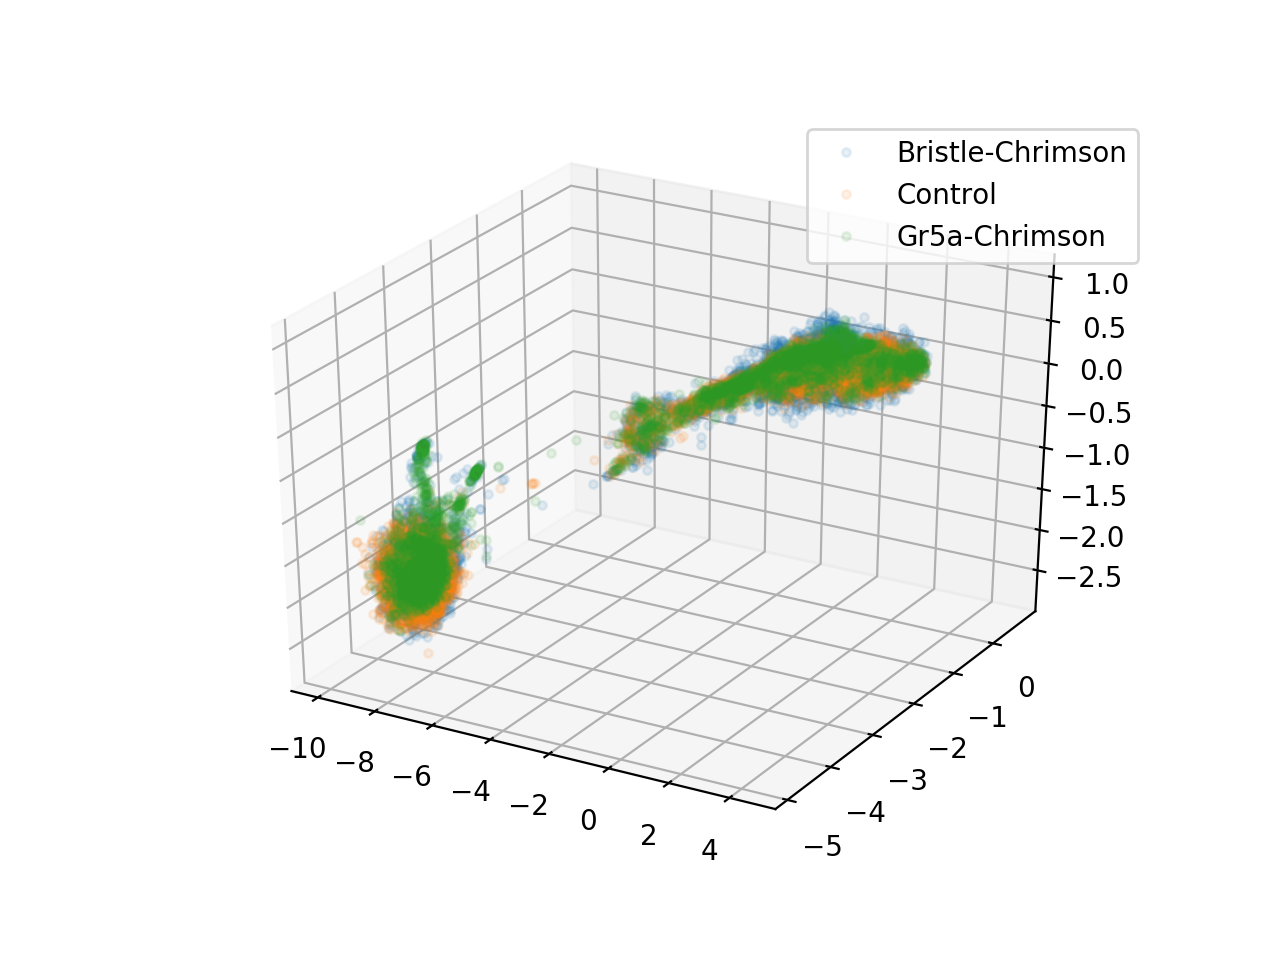

In [12]:
# Make a plot colored by Condition
groups = df.groupby('Condition')
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax = plt.axes()
for name, group in groups:
#     if name == 'Control.csv':
#     if name == 'Bristle-Chrimson.csv':
#     if name == 'Gr5a-Chrimson.csv':    
        ax.plot(group.x, group.y, group.z,  marker='.', linestyle='', alpha=.1, label=name)
#     ax.plot(group.x, group.y,  marker='.', linestyle='', alpha=.1, label=name)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


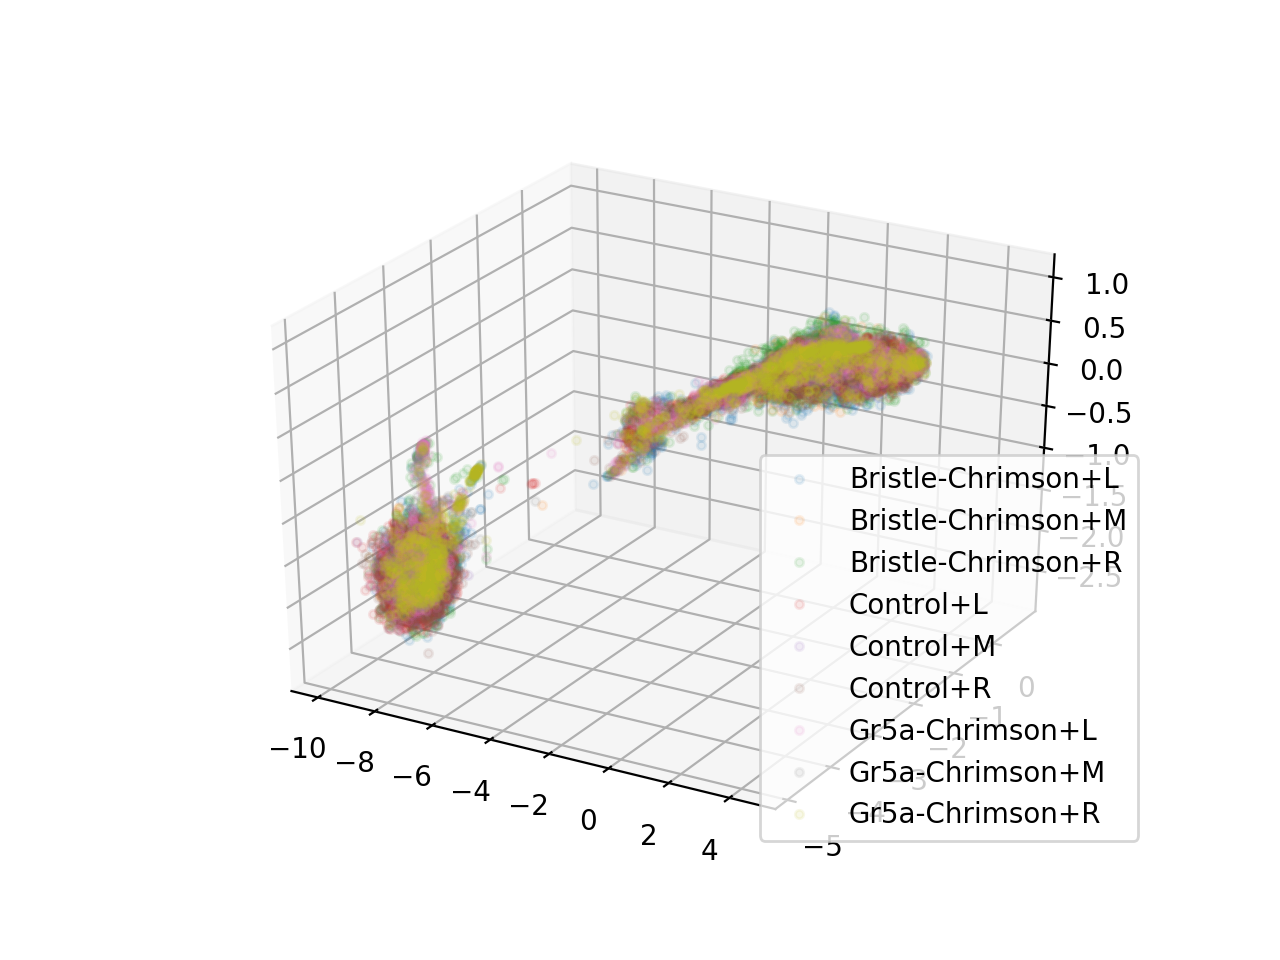

In [13]:
# Make a plot colored by Condition
groups = df.groupby('Combo')
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax = plt.axes()
for name, group in groups:
    ax.plot(group.x, group.y, group.z,  marker='.', linestyle='', alpha=.1, label=name)
#     ax.plot(group.x, group.y,  marker='.', linestyle='', alpha=.1, label=name)
plt.legend()
plt.show()

In [14]:
parent_path = save_path = '/Users/bdeangelis/Desktop/Datasets/OptoMethodDatasets/csv/'

# Write the embedding data to disk in a csv
if body_flag & limb_flag:
    # Keep all data
    save_path = os.path.join(parent_path, f'UMAP_embedding_all-data_{n_neighbors}-neighbors_{n_components}-dims.csv')
elif body_flag:
    # Keep only the body data
    save_path = os.path.join(parent_path, f'UMAP_embedding_body-data_{n_neighbors}-neighbors_{n_components}-dims.csv')
elif limb_flag:
    # Keep only the limb data
    save_path = os.path.join(parent_path, f'UMAP_embedding_limb-data_{n_neighbors}-neighbors_{n_components}-dims.csv')

df.to_csv(save_path, index=False)